In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import random

plt.style.use('ggplot')

In [2]:
train_df = pd.read_pickle('./01_train.dat')
#train_df = atecml.data.load_train()
rej = pd.read_pickle('./reject_inf.dat')
rej_list= list(rej[rej.score>0.5]['id'])
rej_list= list(rej['id'])
print(len(rej_list))
rej_list_index = list(train_df[train_df.id.isin(rej_list)].index)
train_df.loc[rej_list_index,'Fraud']=1

4725


In [3]:


predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]
DateFold={}

DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-12').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-13',end_date='2017-09-20').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-21',end_date='2017-09-28').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-09-29',end_date='2017-10-06').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-07',end_date='2017-10-14').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-15',end_date='2017-11-24').index)

all_list = set(train_df.index) - set(DateFold[5])
len(all_list),len(DateFold[5])

(634284, 360447)

In [4]:
#WOE_LIST = joblib.load('./woe_feature.dat')
#CATE_LIST = WOE_LIST + atecml.data.CATE_FEATURE_LIST

CATE_LIST = atecml.data.CATE_FEATURE_LIST
categorical=[]
for item in predictors:
    if (item in CATE_LIST):
        categorical.append(item)


In [5]:
num_boosting_round = 300
early_stop_round = 100

In [6]:
params = {
    
    'objective': 'binary',
    'metric': 'auc',
    'use_missing' : True,
    #'is_unbalance': True,
    #'scale_pos_weight': 98,
    'learning_rate': 0.5,
    'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 600,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 255,  # Number of bucketed bin for feature values
    'colsample_bytree': 0.7,
    'subsample': 0.85,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'min_child_weight': 0.01,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    #'subsample_for_bin': 2000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0.01,  # L1 regularization term on weights
    'reg_lambda': 0.1,  # L2 regularization term on weights
    'nthread': 40,
    'n_estimators': num_boosting_round,
    'verbose': -1,
}

rf = {
    'boosting_type': 'rf',
}
rf.update(params)

dart = {
    'boosting_type': 'dart',
}
dart.update(params)

gbdt = {
    'boosting_type': 'gbdt',
}
gbdt.update(params)

param_list = [gbdt,dart]

In [7]:
model_list  =[]

for idxn in tqdm(range(0,20)):
    idx = idxn//4
    Train_DataSet = train_df[train_df.index.isin(list(all_list - DateFold[idx]))].reset_index(drop=True)
    Normal_DF = Train_DataSet[Train_DataSet['label']==0]
    Fraud_DF = Train_DataSet[Train_DataSet['label']==1]
    
    number_record_fraud = len(Fraud_DF)
    number_record_normal = len(Normal_DF)
    #undersample
    random_normal_indices = np.array(np.random.choice(Normal_DF.index,number_record_fraud,replace=False))
    filter_list = list(random_normal_indices) + list(Fraud_DF.index)
    under_sample_train = Train_DataSet[Train_DataSet.index.isin(filter_list)].reset_index(drop=True)
    
    Val_DataSet = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)
    X_train = under_sample_train[predictors]
    y_train = under_sample_train['Fraud']

    X_test = Val_DataSet[predictors]
    y_test = Val_DataSet['Fraud']
    
    for item_params in (param_list):
        gbm = lgb.LGBMClassifier(**item_params)
        print('starting fit model...')
        gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)],eval_metric='auc',early_stopping_rounds=early_stop_round,verbose=200,categorical_feature=categorical)
        model_list.append(gbm)  

  0%|          | 0/20 [00:00<?, ?it/s]

starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's auc: 0.969882
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.971037


  5%|▌         | 1/20 [00:51<16:22, 51.72s/it]

Did not meet early stopping. Best iteration is:
[250]	valid_0's auc: 0.972301
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	valid_0's auc: 0.969765
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.971555


 10%|█         | 2/20 [01:39<14:51, 49.52s/it]

Did not meet early stopping. Best iteration is:
[262]	valid_0's auc: 0.972669
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	valid_0's auc: 0.970933
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.970828


 15%|█▌        | 3/20 [02:21<13:24, 47.31s/it]

Early stopping, best iteration is:
[112]	valid_0's auc: 0.971596
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's auc: 0.969916
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.970822


 20%|██        | 4/20 [03:11<12:44, 47.81s/it]

Did not meet early stopping. Best iteration is:
[247]	valid_0's auc: 0.971709
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's auc: 0.967788
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.968837


 25%|██▌       | 5/20 [03:56<11:49, 47.28s/it]

Early stopping, best iteration is:
[141]	valid_0's auc: 0.97097
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's auc: 0.967194
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.969439


 30%|███       | 6/20 [04:40<10:53, 46.71s/it]

Early stopping, best iteration is:
[115]	valid_0's auc: 0.970741
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's auc: 0.969796
starting fit model...
Training until validation scores don't improve for 100 rounds.


 35%|███▌      | 7/20 [05:22<09:59, 46.10s/it]

Early stopping, best iteration is:
[99]	valid_0's auc: 0.97217
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.966306
Early stopping, best iteration is:
[157]	valid_0's auc: 0.968135
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.97064


 40%|████      | 8/20 [06:14<09:22, 46.85s/it]

Early stopping, best iteration is:
[191]	valid_0's auc: 0.971584
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[44]	valid_0's auc: 0.967523
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.970237


 45%|████▌     | 9/20 [06:58<08:31, 46.48s/it]

Early stopping, best iteration is:
[153]	valid_0's auc: 0.970439
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[62]	valid_0's auc: 0.969745
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.969109


 50%|█████     | 10/20 [07:43<07:43, 46.35s/it]

Early stopping, best iteration is:
[129]	valid_0's auc: 0.970603
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[33]	valid_0's auc: 0.970189
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.969735


 55%|█████▌    | 11/20 [08:25<06:53, 45.92s/it]

Early stopping, best iteration is:
[112]	valid_0's auc: 0.971841
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[29]	valid_0's auc: 0.968159
starting fit model...
Training until validation scores don't improve for 100 rounds.


 60%|██████    | 12/20 [09:04<06:03, 45.39s/it]

Early stopping, best iteration is:
[77]	valid_0's auc: 0.968653
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[76]	valid_0's auc: 0.969423
starting fit model...
Training until validation scores don't improve for 100 rounds.


 65%|██████▌   | 13/20 [09:48<05:16, 45.25s/it]

Early stopping, best iteration is:
[88]	valid_0's auc: 0.971525
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[28]	valid_0's auc: 0.968329
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.969452


 70%|███████   | 14/20 [10:35<04:32, 45.41s/it]

Did not meet early stopping. Best iteration is:
[287]	valid_0's auc: 0.97057
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[34]	valid_0's auc: 0.966858
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.969424


 75%|███████▌  | 15/20 [11:19<03:46, 45.31s/it]

Early stopping, best iteration is:
[123]	valid_0's auc: 0.970206
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	valid_0's auc: 0.968329
starting fit model...
Training until validation scores don't improve for 100 rounds.


 80%|████████  | 16/20 [11:58<02:59, 44.90s/it]

Early stopping, best iteration is:
[48]	valid_0's auc: 0.970457
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	valid_0's auc: 0.965313
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.966412


 85%|████████▌ | 17/20 [12:46<02:15, 45.09s/it]

Did not meet early stopping. Best iteration is:
[239]	valid_0's auc: 0.967752
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[81]	valid_0's auc: 0.967219
starting fit model...
Training until validation scores don't improve for 100 rounds.


 90%|█████████ | 18/20 [13:29<01:29, 45.00s/it]

Early stopping, best iteration is:
[77]	valid_0's auc: 0.969595
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	valid_0's auc: 0.969182
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.970415


 95%|█████████▌| 19/20 [14:17<00:45, 45.15s/it]

Did not meet early stopping. Best iteration is:
[269]	valid_0's auc: 0.970973
starting fit model...
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[73]	valid_0's auc: 0.966504
starting fit model...
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.967392


100%|██████████| 20/20 [15:06<00:00, 45.31s/it]

Did not meet early stopping. Best iteration is:
[236]	valid_0's auc: 0.968867


In [8]:
val_df = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)
val_df1 = val_df.head(180000)
val_df2 = val_df[~val_df.index.isin(list(val_df1.index))]

In [9]:
val_r_neg=pd.DataFrame()
for idx in tqdm(range(0,len(model_list))):
    model_neg = model_list[idx]
    val_neg = model_neg.predict_proba(val_df[predictors])
    val_r_neg[idx] = pd.DataFrame(val_neg)[1]
    
    

100%|██████████| 40/40 [05:38<00:00,  8.45s/it]


Ant-Score: 0.38874700718276134


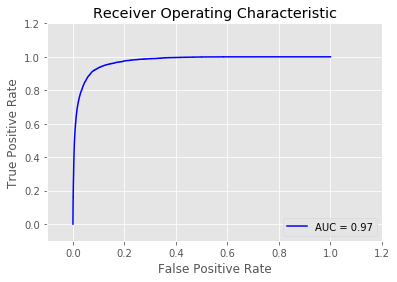

In [10]:
#pos_mean = val_r_pos.mean(axis=1)
neg_mean = val_r_neg.mean(axis=1)
_,_,_ = atecml.data.accuracy_validation(val_df['Fraud'],neg_mean)

In [11]:
def stack_result(X_train,model_list):
    with atecml.data.timer('Classification: Building Layer-1 Stack'):
        input_list = []
        for idx in tqdm(range(len(model_list))):
            model = model_list[idx]
            _temp_df = pd.DataFrame(model.predict_proba(X_train))[1]
            input_list.append(pd.DataFrame(_temp_df))
        input_predict= np.array(pd.concat(input_list,ignore_index=True,axis=1))
    return input_predict




In [12]:
test_df = atecml.data.load_test()

In [13]:
test_df_level1 = stack_result(test_df[predictors],model_list)


KeyError: "['n_f20' 'n_f88' 'n_f112' 'n_f297' 'n_f234' 'n_f110' 'n_f193' 'n_f67'\n 'n_f289' 'n_f91' 'n_f291' 'n_f171' 'n_f73' 'n_f166' 'n_f128' 'n_f140'\n 'n_f288' 'n_f284' 'n_f48' 'n_f257' 'n_f208' 'n_f97' 'n_f200' 'n_f282'\n 'n_f82' 'n_f177' 'n_f173' 'n_f198' 'n_f108' 'n_f135' 'n_f160' 'n_f296'\n 'n_f290' 'n_f66' 'n_f80' 'n_f189' 'n_f109' 'n_f179' 'n_f90' 'n_f138'\n 'n_f255' 'n_f123' 'n_f79' 'n_f210' 'n_f150' 'n_f56' 'n_f139' 'n_f209'\n 'n_f196' 'n_f143' 'n_f258' 'n_f129' 'n_f287' 'n_f94' 'n_f182' 'n_f167'\n 'n_f23' 'n_f141' 'n_f85' 'n_f159' 'n_f149' 'n_f87' 'n_f267' 'n_f96'\n 'n_f99' 'n_f158' 'n_f170' 'n_f286' 'n_f17' 'n_f174' 'n_f197' 'n_f254'\n 'n_f69' 'n_f203' 'n_f83' 'n_f192' 'n_f294' 'n_f187' 'n_f101' 'n_f180'\n 'n_f78' 'n_f293' 'n_f68' 'n_f295' 'n_f175' 'n_f207' 'n_f77' 'n_f124'\n 'n_f273' 'n_f107' 'n_f54' 'n_f154' 'n_f22' 'n_f202' 'n_f12' 'n_f172'\n 'n_f183' 'n_f92' 'n_f75' 'n_f285' 'n_f256' 'n_f292' 'n_f178' 'n_f18'\n 'n_f281' 'n_f201' 'n_f14' 'n_f191' 'n_f32' 'n_f81' 'n_f199' 'n_f98'\n 'n_f71' 'n_f119' 'n_f102' 'n_f181' 'n_f269' 'n_f74' 'n_f9' 'n_f168'\n 'n_f95' 'n_f272' 'n_f156' 'n_f72' 'n_f103' 'n_f111' 'n_f105' 'n_f100'\n 'n_f280' 'n_f194' 'n_NaN_LIST' 'n_f195' 'n_f86' 'n_f21' 'n_f16' 'n_f106'\n 'n_f186' 'n_f93' 'n_f155' 'n_f188' 'n_f283' 'n_f176' 'n_f190' 'n_f278'\n 'n_f70' 'n_f118' 'n_f169' 'n_f137' 'n_f136' 'n_f157' 'n_f89' 'n_f268'\n 'n_f279' 'n_f55' 'mean'] not in index"

In [ ]:
y_pred = test_df_level1.mean(axis=1)

In [ ]:
result=pd.DataFrame()
result['id'] = test_df['id']
result['score'] = y_pred
result.to_csv('./0706_07.csv',index=False)

In [ ]:
level2_model_list  =[]
# use XGBOOST  as the model of the second layer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


for idxn in range(0,15):
    idx = idxn//3
    
    Train_DataSet = train_df[train_df.index.isin(list(all_list - DateFold[idx]))].reset_index(drop=True)
    Normal_DF = Train_DataSet[Train_DataSet['label']==0]
    Fraud_DF = Train_DataSet[Train_DataSet['label']==1]
    
    number_record_fraud = len(Fraud_DF)
    number_record_normal = len(Normal_DF)
    #undersample
    random_normal_indices = np.array(np.random.choice(Normal_DF.index,number_record_fraud,replace=False))
    filter_list = list(random_normal_indices) + list(Fraud_DF.index)
    under_sample_train = Train_DataSet[Train_DataSet.index.isin(filter_list)].reset_index(drop=True)
    
    Val_DataSet = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)
    X_train = Train_DataSet[predictors]
    y_train = Train_DataSet['Fraud']
    
    X_test = Val_DataSet[predictors]
    y_test = Val_DataSet['Fraud']    
    
    
    model = XGBClassifier(
                         learning_rate =0.05,
                         n_estimators=400,
                         max_depth=3,
                         min_child_weight=1,
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.9,
                         objective= 'binary:logistic',
                         scoring='roc_auc',
                         #scale_pos_weight= 98,
                         nthread=40,
                         seed=27)
    
    X_train_level2 = stack_result(X_train,model_list)
    X_test_level2 = stack_result(X_test,model_list)
    eval_set  = [(X_train_level2,y_train), (X_test_level2,y_test)]
    
    model.fit(X_train_level2,y_train,eval_set=eval_set,eval_metric='auc',early_stopping_rounds=200)  
    level2_model_list.append(model)
        

In [ ]:
val_df2_level2 = stack_result(val_df[predictors],model_list)
foo = stack_result(val_df2_level2,level2_model_list)


In [ ]:
y_pred= pd.DataFrame(foo).mean(axis=1)
_,_,_ = atecml.data.accuracy_validation(val_df['Fraud'],y_pred)

In [ ]:
test_df = atecml.data.load_test()

In [ ]:
test_df_level1 = stack_result(test_df[predictors],model_list)
test_df_level2 = stack_result(test_df_level1,level2_model_list)

In [ ]:
y_pred= pd.DataFrame(test_df_level2).mean(axis=1)

In [ ]:
result=pd.DataFrame()
result['id'] = test_df['id']
result['score'] = y_pred

In [ ]:
result.to_csv('./0707_01.csv',index=False)

In [ ]:
unknown_df =atecml.data.load_train()

In [ ]:
unknown_df = unknown_df[unknown_df.label==-1]

In [ ]:
un_level1 = stack_result(unknown_df[predictors],model_list)
un_level2 = stack_result(un_level1,level2_model_list)

In [ ]:
un_pred= pd.DataFrame(un_level2).min(axis=1)
unresult=pd.DataFrame()
unresult['id'] = unknown_df['id']
unresult['score'] = un_pred
#unresult.to_pickle('./reject_inf.dat')

In [ ]:
un_pred.hist(bins=100)

In [ ]:
len(un_pred[un_pred>0.5])